# Informations

To use this script, you have to start with .needle files.
It's important to use the same sample sheet than part 1. You'll also need the reads_count excel sheet to add more informations to it.
I made the script so you don't have to change anything except in the set up section.

## This is the part 2 of the analysis. 

### Analysis pipeline : 
### 1- Parse_needle_output() from .needle files
### 2- Find_mutations() from the parse_needle_output()
### 3- get_variant_count_1() from Find_mutations() output.
### 4- Heatmaps

## I'm running this code locally on windows (don't need to be using the subsystem for that) or on the server.

# Import

In [1]:
import gzip
import Bio
import subprocess
import openpyxl
from Bio import SeqIO
import os,sys,re

import pandas as pd
print(pd.__name__, pd.__version__)

import numpy as np
print(np.__name__, np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__name__, matplotlib.__version__)
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

import scipy.stats as stats
import scipy
print(scipy.__name__, scipy.__version__)

import seaborn as sns
print(sns.__name__, sns.__version__)

from collections import Counter

pandas 1.5.2
numpy 1.22.4
matplotlib 3.3.4
scipy 1.6.2
seaborn 0.12.2


# Set up
Ideally this is the only cell which has to be modified.

In [26]:
##see the sample sheet to know how to fill it
##info = dataframe of the sample_sheet
## wt = the path to the wt sequence in a .fa file
## wt_seq = wt sequence directly in a string
## *the wt sequence has to be without the primers, so how it will be once trimmed.

date = "2023-06-20" #date your doing the analysis, used to save figures
experiment = "CaERG11-F2-Part2" #generic name of your experiment, used to save figures
reads_folder = "./CaERG11-F2/" #location of the reads in .gz
merged_folder = "./CaERG11-F2-merged_reads/" # location of merged reads
figures_folder = "./CaERG11-F2-figures/" # location of the figures
trim_folder = "./CaERG11-F2-Trimmed/" #location of trimmed reads
agg_folder = "./CaERG11-F2-Aggregated/" #location of aggregated reads
needle_folder = "./CaERG11-F2-Needle/" #location of reads aligned to wt (.needle)
variants_folder = "./CaERG11-F2-variants/" #location of the variants count
reads_counts_folder = "./CaERG11-F2-ReadsCount/" #location of all dataframes output in excel format with reads counts 
heatmaps_folder = "./CaERG11-F2-Heatmaps/" #location of all heatmaps

sample_sheet = "./sample_sheet_F2_all.xlsx" #excel sheet with all the information
reads_count = reads_counts_folder + "Reads_count_CaERG11-F2_2023-06-20.xlsx"

pe = 250 #paired-end

before_nut = 2 #number of nucleotides before the first complete codon of your sequence (0, 1 or 2)
after_nut = 0 #number of nucleotides after the last complete codon of your sequence (0, 1 or 2)

aa_start = 154 #first amino acid of your sequence (complete codon)
aa_end = 282 #last amino acid of your sequence (complete codon)

wt = "./CaERG11_wt_seq/CaERG11_F2_wt_seq.fasta" #your WT sequence AFTER trimming
wt_seq = "TCATTCAAAAGGTATGTACCCAAAATTCGTGAAGAAATATTAAACTATTTCGTAACAGACGAAAGTTTCAAATTAAAGGAAAAGACACACGGCGTGGCTAACGTGATGAAAACACAACCTGAAATCACCATTTTTACCGCCAGCAGGTCCTTATTTGGCGACGAGATGAGAAGAATTTTCGATAGAAGTTTTGCTCAACTGTACTCAGATTTGGATAAAGGTTTTACTCCGATAAATTTCGTGTTCCCAAACCTTCCTTTGCCACACTATTGGAGAAGAGATGCTGCACAAAAGAAGATAAGTGCGACCTATATGAAAGAGATAAAATCCCGTAGGGAAAGGGGTGACATTGACCCTAACAGAGACTTGATTGATTCTCTGCTGATT"
pos_mutated = [154,155,158,162,192,195,196,197,199,200,201,202,203,204,205,224,225,226,227,228,229,230,231,232,233,234,235,238,243,246,257,275,276,277,280]
codons_mutated = ["GCT","GCC","TGC","TGT","GAT","GAC","GAG","GAA",
"TTC","TTT","GGT","GGA","CAC","CAT","ATC","ATT","AAG","AAA","TTG","TTA","ATG","AAC","AAT","CCT","CCA","CAG","CAA",
"AGA","CGT","TCT","TCC","ACC","ACT","GTT","GTC","TGG","TAC","TAT","TAA"] 
codons_all = ["GCT","GCC","TGC","TGT","GAT","GAC","GAG","GAA",
"TTC","TTT","GGT","GGA","CAC","CAT","ATC","ATT","AAG","AAA","TTG","TTA","ATG","AAC","AAT","CCT","CCA","CAG","CAA",
"AGA","CGT","TCT","TCC","ACC","ACT","GTT","GTC","TGG","TAC","TAT","TAA","GTA","GCA","GTG","ATA","GCG","CTC","CTA","CGG",
"TAG","TGA","CCC","GGG","TCG","AGG","CGA","CGC","AGT","CTG","ACG","TCA","AGC","GGC","CTT","ACA","CCG"]
wt_len = len(wt_seq)
wt_aa="SFKRYVPKIREEILNYFVTDESFKLKEKTHGVANVMKTQPEITIFTASRSLFGDEMRRIFDRSFAQLYSDLDKGFTPINFVFPNLPLPHYWRRDAAQKKISATYMKEIKSRRERGDIDPNRDLIDSLLI"

In [27]:
wt_len

357

In [28]:
info = pd.read_excel(sample_sheet, header=0, index_col=0)
reads = pd.read_excel(reads_count, header=0, index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: './CaERG11-F1-ReadsCount/Reads_count_CaERG11-F1_2023-03-09.xlsx'

# Parse the needle output to get variants

We define a bunch of function and then we use them all at the same time.

In [29]:
def parse_needle_output(path):
    # this function parses the needle alignments and extract the aligned sequences reference and query seuqences. 
    # It takes as input the path to the needle output
    
    n_aligns = 0
    # counter for the number of alignments
    
    align_seqs_dict = {}
    # empty container that will hold the aligned sequences
                
    needle_align_path = path
    # path to the alignments
        
    with open(needle_align_path, 'r') as source:
        # open the alignment

        current_align = ''
        current_qseq = ''
        current_sseq = ''
        # empty container objects for data processing
        
        qseq_done = 0
        #counter for the number of alignments processed

        for line in source:
            # loop through the file

            if line.startswith('>>>') == True:
                # detect headers

                n_aligns +=1
                # increment alignment counter by one

                align_name = line.strip('>>>')
                # get alignment name

                if n_aligns != 1:
                    # if this is not the first alignment

                    align_seqs_dict[current_align] = [current_qseq, current_sseq]
                    # add the information on the previous alignment to the dict

                    current_align = align_name
                    # update the name for the new entry

                    current_qseq = ''
                    current_sseq = ''
                    # reset temporary variables

                    qseq_done = 0
                    # reset indicator for query sequence extraction

                else:
                    current_align = align_name
                    # for the fisrt sequence, just need to store the align name

 
            elif line.startswith(';') == False and line.startswith('>') == False and line.startswith('\n') == False and line.startswith('#') == False:
                # skip all the useless lines to process only the aligned sequences

                if qseq_done == 1:
                    current_sseq += line.strip('\n')
                    # if the query seq is done (qseq = 1), add sequence to the subject

                else:
                    current_qseq += line.strip('\n')
                    # if the query seq is not done, continue to update it

            elif line.startswith('#--') == True:
                align_seqs_dict[align_name] = [current_qseq, current_sseq]
                # update dict with info from the last entry in the alignment sequence

            else:
                if qseq_done == 0 and current_qseq != '':
                    qseq_done =1
                    # if the qseq is recorded, update value
                
                    
    return align_seqs_dict, n_aligns

In [30]:
def find_mutations(path,ref_orf):
    # For a given path and reference sequence, runs the Needle alignment parser and
    # then goes through the extracted alignments to find the differences between the aligned query and the reference.
    #
    
    allele_dict = {}
    # empty dict that will hold the sequence name :mutations information
    
    # here you associate the sample name in the sample_dataframe (frag) to the name in the fasta files (ref_orf)
    ref_orf = ref_orf
    # depending on the sample, select the approptiate reference sequence #give file name
    
    align_dict, align_count = parse_needle_output(path)
    # get the parsed alignments for the sample
    
    for entry in list(align_dict.keys()):
        # loop through aligned sequences

        read_var_list = []
        # temporary holder for mutations found in sequence

        query_seq = align_dict[entry][1]
        # aligned cds sequence of the strain

        align_ref = align_dict[entry][0]
        # aligned cds sequence of the reference

        gap_adjust = 0
        # value used to adjust the cds sequence index for the presence of insertions in the strain sequence vs the 
        # reference cds

        backtrack_adjust = 0
        # value used to adjust the cds sequence index for the presence of deletions in the strain sequence vs the 
        # reference cds

        temp_var = None
        # temporary variable to hold the sequence of an insertion or deletion as a string. When the gap ends, annotation 
        # will be added to read_var_list

        indel_start = 0
        # position start of the indel annotation in the reference sequence, with adjustment for gap presence

        ref_seq_no_gaps = align_ref.replace('-','')
        # reference sequence with gaps removed

        align_start = 0
        # position in the reference fragment where the alignment starts

        query_seq_no_gaps = len(query_seq.replace('-',''))
        # length of the query when gaps are removed

        for nt in range(0, len(align_ref)):
            # iterates through the entire alignment of the strain prot sequence

            if query_seq[nt] == '-':
                # detect a deletion variant

                # logic for indel detection/annotation:
                #
                # suppose we have this alignment  
                #
                # 1 2 3 4 5 6 7 8 9
                # A T - - A A A T G    strain variant: del gaps are indexed because the aa index is based on reference
                # A T K P A - - T G
                # 1 2 3 4 5     6 7    reference: insert gaps not indexed because aa positions do exist in reference
                #
                # following this logic, every time an insertion is detected and annotated, the gap_adjust value is 
                # incremented by the length of the gap and used to adjust the variant mapping to make it match the 
                # reference index values. The indel aa postion is the first residue detected as part of the indel


                if indel_start == 0:
                    # checks if the character is the start or the continuation of a gap in the alignment

                    temp_var = 'del'+ align_ref[nt]
                    indel_start = (nt+1-gap_adjust)
                    # if it is, starts a new annotation entry with a start position compensated for previous insertions
                    # (if any)

                    backtrack_adjust += 1

                else:

                    temp_var += align_ref[nt]
                    # if it is not, adds the following aa to the deletion annotation

                    backtrack_adjust += 1


            elif align_ref[nt] == '-':
                # detects an insertion variant

                if indel_start == 0:
                    # checks if the character is the start or the continuation of a gap in the alignment

                    temp_var = 'ins'+ query_seq[nt]

                    indel_start = (nt+1-gap_adjust)
                    # if it is, starts a new annotation entry with a start position compensated for previous insertions
                    # (if any)

                    gap_adjust += 1
                    # increments the gap adjust for the this added aa in the strain sequence                   


                else:

                    temp_var += query_seq[nt]
                    # if it is not, adds the following aa to the insertion annotation

                    gap_adjust += 1
                    # increments the gap adjust for the this added aa in the strain sequence


            elif query_seq[nt] != align_ref[nt]:
                # detects a mismatch between the strain sequence and the reference


                variant = align_ref[nt]+'|'+str((nt+1-gap_adjust))+'|'+query_seq[nt]
                read_var_list.append(variant)
                # creates an annotation for the strain-reference aa mismatch and appends it to the list of 
                # annotations

            else:

                 if indel_start != 0:
                    # detects if there is currently an open gap entry. If there is, then the detected mismatch means 
                    # that it has now concluded

                    read_var_list.append(str((indel_start))+temp_var)
                    temp_var = None
                    indel_start = 0
                    # adds the indel annotation to the strain variant list and resets temporary variables for the next 
                    # indel entry


        if query_seq_no_gaps >=  len(ref_seq_no_gaps)*0.8 and len(read_var_list)<25:             
            allele_dict[entry] = read_var_list, align_start
            # apply a filter for alignment quality: the alignment must cover at least 80% of the reference sequence and
            # there must be less than 3 differences between the query and the reference (insertions, deletions or SNVs)
            #not be bigger tha the size of the reference
                           
    return allele_dict

In [31]:
after_align_dict = {}

def get_n_align(allele_dict):
    # for a given dict (sequence: mutations), add up the number of
    # aggregated sequences for each entry to get the total number of 
    # reads that passed the alignment filter
    
    n_align = 0
    # counter
    
    for seq in list(allele_dict.keys()):
        # loop through entries in the dict
        
        var_info = seq.split(',')
        var_count =int(var_info[1].split(';')[1].strip('size='))
        # get the number of reads for a specific sequence
        
        n_align += var_count
        # add it to the count
        after_align_dict[str(info.loc[Sample]["Name"])] = n_align
    return n_align
    # return the total

In [32]:
def get_variant_count_1(mutation_set, ref_seq, frag_start, codon_start, n_aa):
    
    variant_abundance_dict ={}
    # container that will store the abundance of protein variants
    
    variants = list(mutation_set.keys())
    # list of detected variants from the find_mutations output
    
    codon_groups = {}
    # This dict will hold the positions in the reference cds that correspond to the same codon.
    # This allows for easy verification that detected mutations occur within the same codon later 
    # downstream in the function
    
    codon = codon_start-1  #important needs to stay like this
    # counter for codon position in the fragment
    
    wt_count =0
    valid_seq=0
    # counters for the number of WT cds detected and the number sequences passing the quality filter
    
    for nt in range(0, n_aa*3):
        # loops through the cds positions in the fragment
        
        pos = nt+1 ###important needs to stay like that
        # adds the primer region offset specific to the fragment
        
        if nt % 3 == 0:
            codon += 1
            # use modulo to delimit and increment codons
            
        codon_groups[pos] = codon
        # add cds position to dict of codon groups
        
        variant_abundance_dict[codon] = {}
        # make an empty container of codon abundances for this specific codon
        
    wt_codons = {}
    # container for the WT codons of the fragment
        
    ref = ref_seq
    # reference dna sequence
    
    for aa in range(0, n_aa):
        # for each amino acid in the fragment
        
        offset = 0
        start = offset+(aa*3)
        # define the starting position of the codon in the DNA sequence based on 
        # aa position and offset
        
        wt_codon=ref[start:(start+3)]  

        wt_codons[(aa+codon_start)] = wt_codon
        # extract WT codons from sequence and add it to the dict
        
        variant_abundance_dict[aa+codon_start][wt_codon]=np.nan 
        # set abundance to nan for wt codons at each positions (the WT sequence
        # is the same across all positions, so impossible to distinguish)          
    
    for variant in variants:
        # loop through detected sequence variants
        
        var_info = variant.split(',')
        var_count =int(var_info[1].split(';')[1].strip('size='))
        # extract the number of counts
               
        mut_list = mutation_set[variant][0]
        # get the list of differences between the sequence and the reference
        
        filtered_list = []
        # list of mutations after filtering
        
        if var_count>=20:
            # check variant abundance against arbitrary threshold. For QC purpose, to see what bias
            # might exist in low abundance sequences
        
            for mutation in mut_list:
                if 'del' in mutation:
                    # loops through mutations to find deletions
                    
                    mut_info = mutation.split('del')
                    mut_pos = int(mut_info[0])
                    # extract deletion position
                    
                    if mut_pos == 1:
                        mut_list.remove(mutation)
                        # if the insertion is at the start (primer region),
                        # ignore it
                        
            if len(mut_list) <=3 and 'ins' not in str(mut_list) and 'del' not in str(mut_list):
                # filter variants: no indels, and not more than three SNVs
                
                if len(mut_list) ==0:
                    wt_count += var_count
                    # if not mutations are found, add counts to the WT genotype
                    
                else:
                    mut_nt_list = []
                    out_list = []
                    # containers for the codons where mutations in the cds occured
                    # and those in the primer regions
                    
                    for mutation in mut_list:
                        mut_pos = int(mutation.split('|')[1])
                        # loop through mutations and extract position in the sequence
                        
                        if mut_pos >=1 and mut_pos <= len(ref_seq):
                            mut_nt_list.append(codon_groups[mut_pos])
                            # if mutation is within the cds, add the mutated codon
                            
                        else:
                            out_list.append(mut_pos)
                            # if outside, add to the other list
                        
                    if len(set(mut_nt_list)) == 1:
                        # checks if all the mutations that occured are in the same codon
                        
                        valid_seq+=var_count
                        # if it passes the filter, add the varinat count to the total of valid 
                        # counts
                        
                        codon = int(list(set(mut_nt_list))[0])
                        # extract the codon where the mutation occured
                        
                        wt_seq = wt_codons[codon]
                        # get the WT at the position where the mutation occured
                                                                      
                        new_seq = [x for x in wt_seq]
                        # stores the wt codon in a new object that we will be able to modify
                        # to change the codon
                        
                        for mutation in mut_list:
                            mut_pos = int(mutation.split('|')[1])
                            mutation = mutation.split('|')[2]
                            # loops through the mutations the variant bears, and extract
                            # the changes and their positions
                            
                            codon_pos = (mut_pos-1)%3
                            # convert cds position to position within 
                            
                            new_seq[codon_pos] = mutation
                            # makes the change in the mutable codon object
                            
                        new_codon = ''.join(new_seq)
                        # convert codon from list of nt to a string
                                                   
                        if new_codon in list(variant_abundance_dict[codon].keys()):
                            variant_abundance_dict[codon][new_codon]+=var_count
                            # if the variant had already been observed before, increment the 
                            # read count for it
                            
                        else:
                            variant_abundance_dict[codon][new_codon]=var_count
                            # if not, create a new entry
                            
  
                        
                    elif len(set(mut_nt_list)) == 0 and len(out_list)>=1:
                        wt_count+=var_count
                        # if no mutations occured in the cds (all in the primer region)
                        # increment the WT seq counts
                    
                    
        elif var_count < 20:
            # check variant abundance against arbitrary threshold. For QC purpose, to see what bias
            # might exist in low abundance sequence

            for mutation in mut_list:
                if 'del' in mutation:
                    # loops through mutations to find deletions
                    
                    mut_info = mutation.split('del')
                    mut_pos = int(mut_info[0])
                    # extract deletion position

                    if mut_pos == 1:
                        mut_list.remove(mutation)
                        # if the insertion is at the start (primer region),
                        # ignore it
                  
            if len(mut_list) <=3 and 'ins' not in str(mut_list) and 'del' not in str(mut_list):
                # filter variants: no indels, and not more than three SNVs

                if len(mut_list) ==0:
                    wt_count += var_count
                    # if not mutations are found, add counts to the WT genotype

                else:
                    mut_nt_list = []
                    out_list = []
                    # containers for the codons where mutations in the cds occured
                    # and those in the primer regions

                    for mutation in mut_list:
                        mut_pos = int(mutation.split('|')[1])
                        # loop through mutations and extract position in the sequence

                        if mut_pos >=1 and mut_pos <= len(ref_seq):
                            mut_nt_list.append(codon_groups[mut_pos])
                            # if mutation is within the cds, add the mutated codon

                        else:
                            out_list.append(mut_pos)
                            # if outside, add to the other list

                    if len(set(mut_nt_list)) == 1:
                        # checks if all the mutations that occured are in the same codon
                        
                        valid_seq+=var_count
                        # if it passes the filter, add the varinat count to the total of valid 
                        # counts

                        codon = int(list(set(mut_nt_list))[0])
                        # extract the codon where the mutation occured

                        wt_seq = wt_codons[codon]
                        # get the WT at the position where the mutation occured

                        new_seq = [x for x in wt_seq]
                        # stores the wt codon in a new object that we will be able to modify
                        # to change the codon

                        for mutation in mut_list:
                            mut_pos = int(mutation.split('|')[1])
                            mutation = mutation.split('|')[2]
                            # loops through the mutations the variant bears, and extract
                            # the changes and their positions

                            codon_pos = (mut_pos-1)%3
                            # convert cds position to position within

                            new_seq[codon_pos] = mutation
                            # makes the change in the mutable codon object

                        new_codon = ''.join(new_seq)
                        # convert codon from list of nt to a string
                        
                        if new_codon in list(variant_abundance_dict[codon].keys()):
                            variant_abundance_dict[codon][new_codon]+=var_count
                            # if the variant had already been observed before, increment the 
                            # read count for it
                            
                        else:
                            variant_abundance_dict[codon][new_codon]=var_count
                            # if not, create a new entry

                    
    return variant_abundance_dict, wt_count

CaERG11_0_None_F1_1_L001


<ipython-input-33-18144a0b1ff6>:24: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  df.to_excel(f"{name}.xlsx")    ##save it
<ipython-input-33-18144a0b1ff6>:32: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  df2.to_excel(f"{name}.xlsx")    ##save it
<ipython-input-33-18144a0b1ff6>:81: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  df2_freq.to_excel(f"{name}.xlsx")    ##save it


FileNotFoundError: [Errno 2] No such file or directory: './CaERG11-F1-Needle/CaERG11_0_None_F1_2_L001.needle'

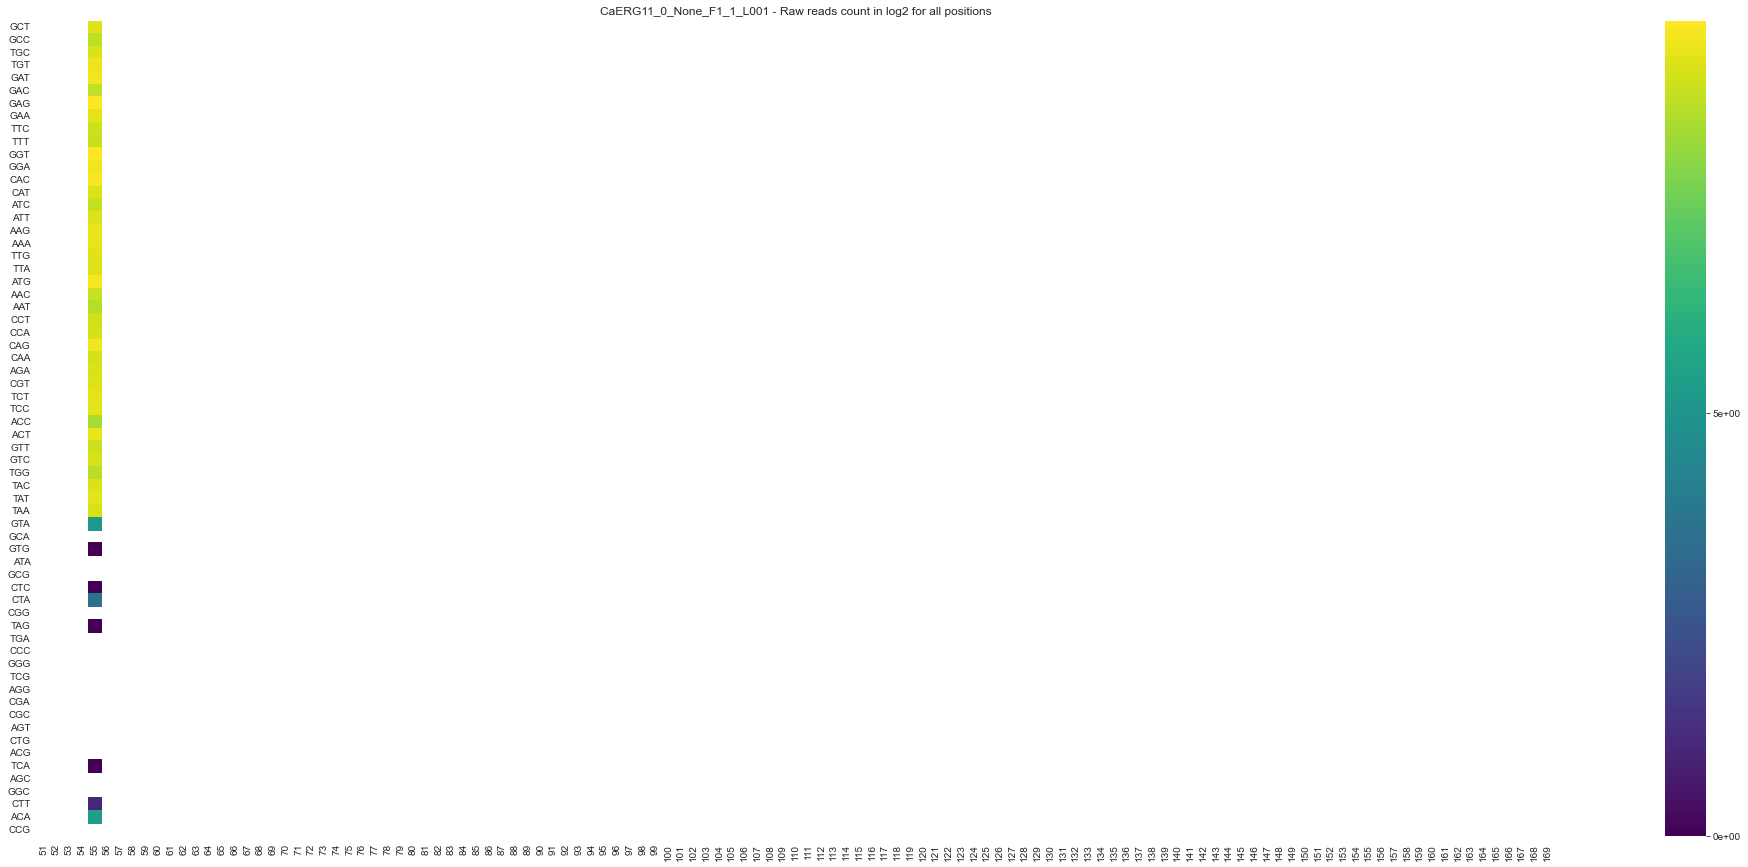

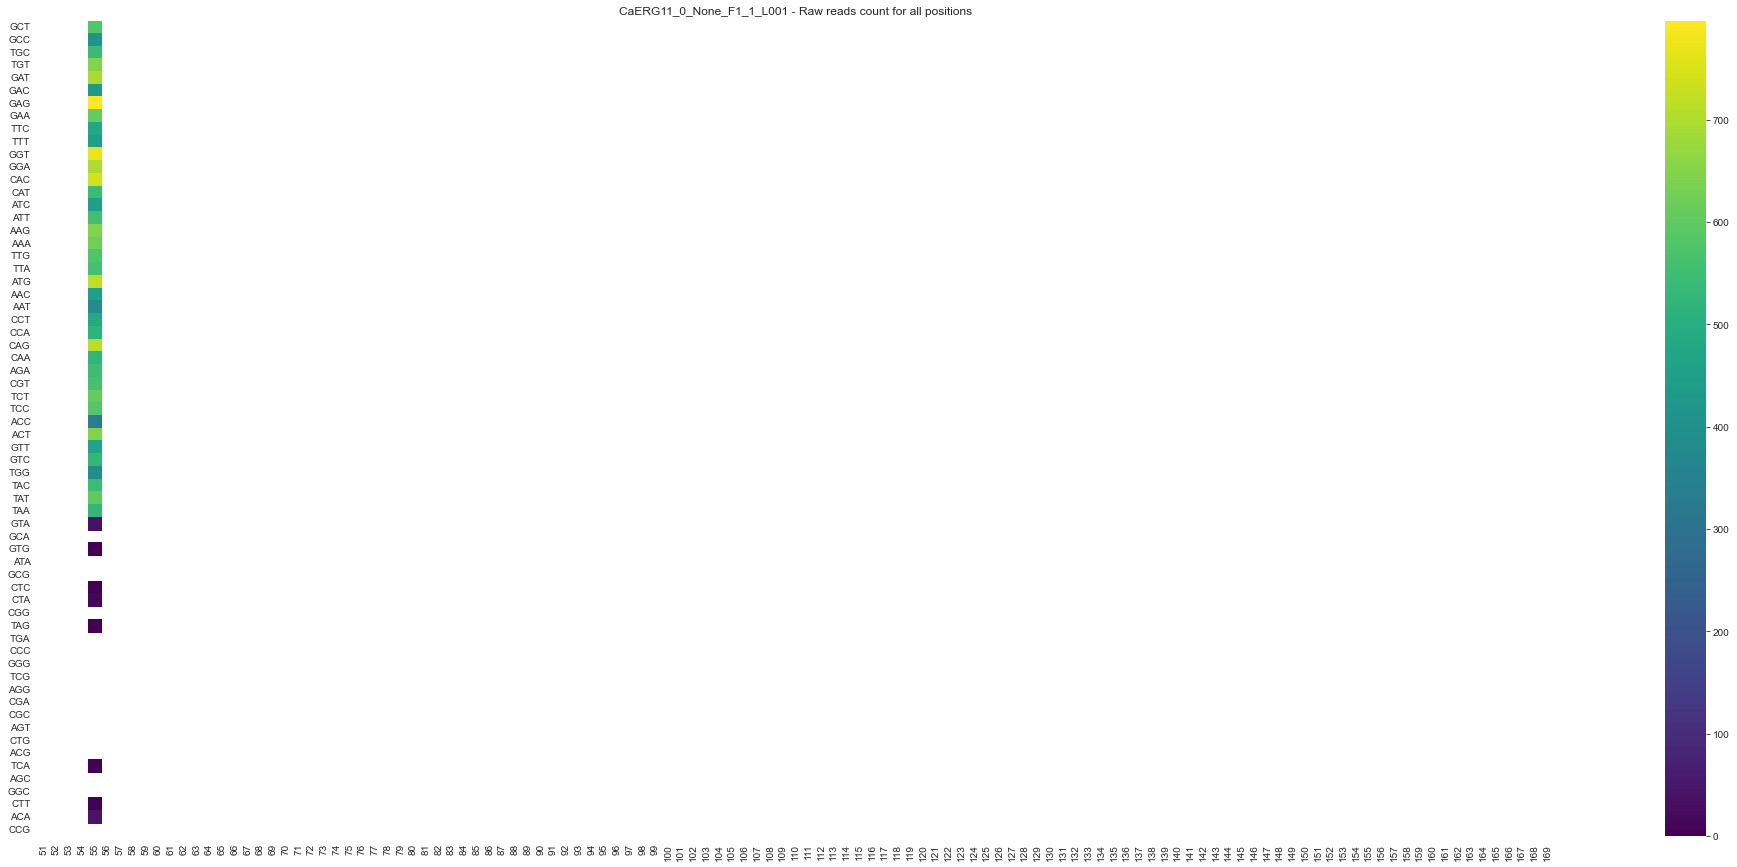

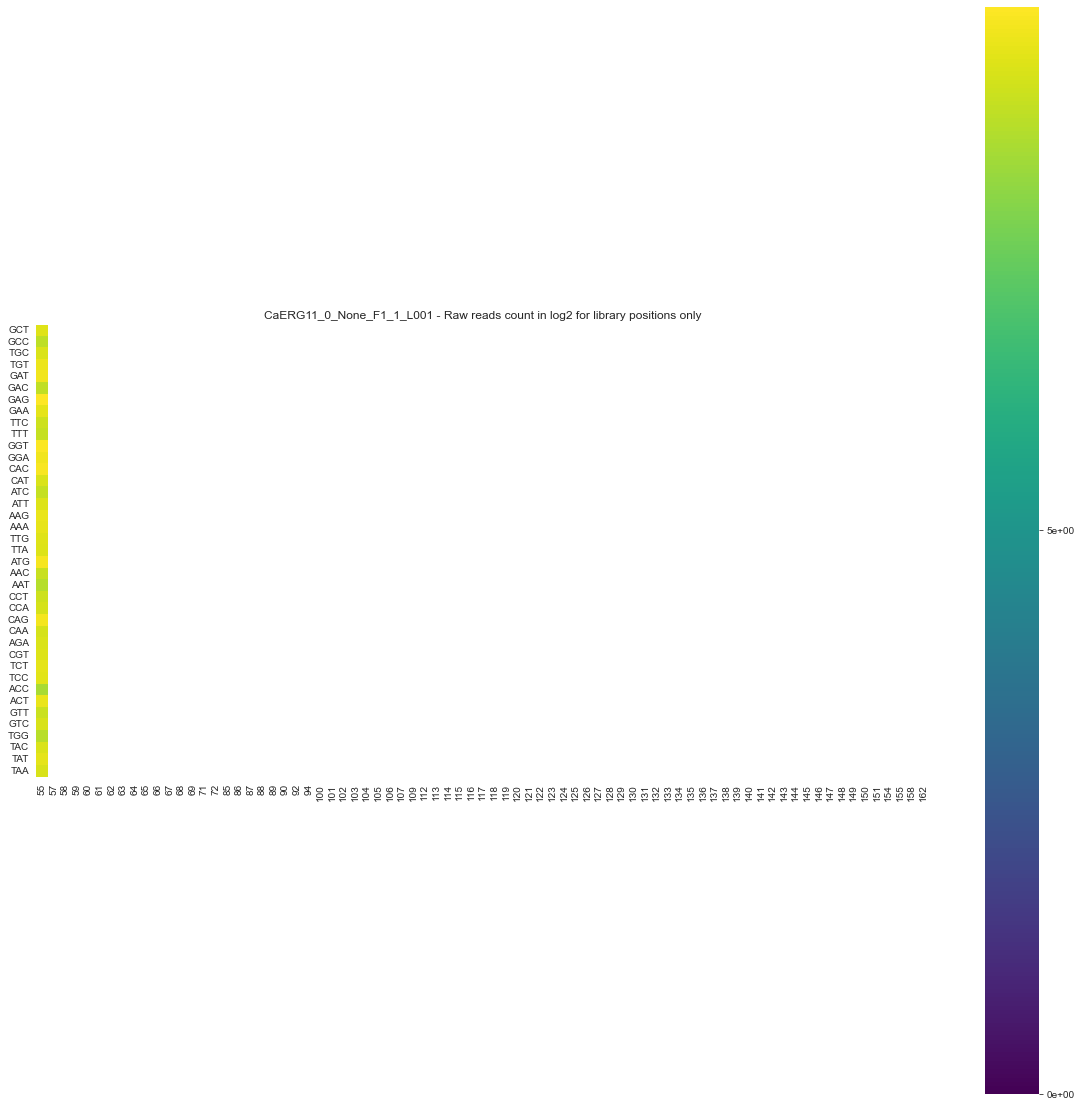

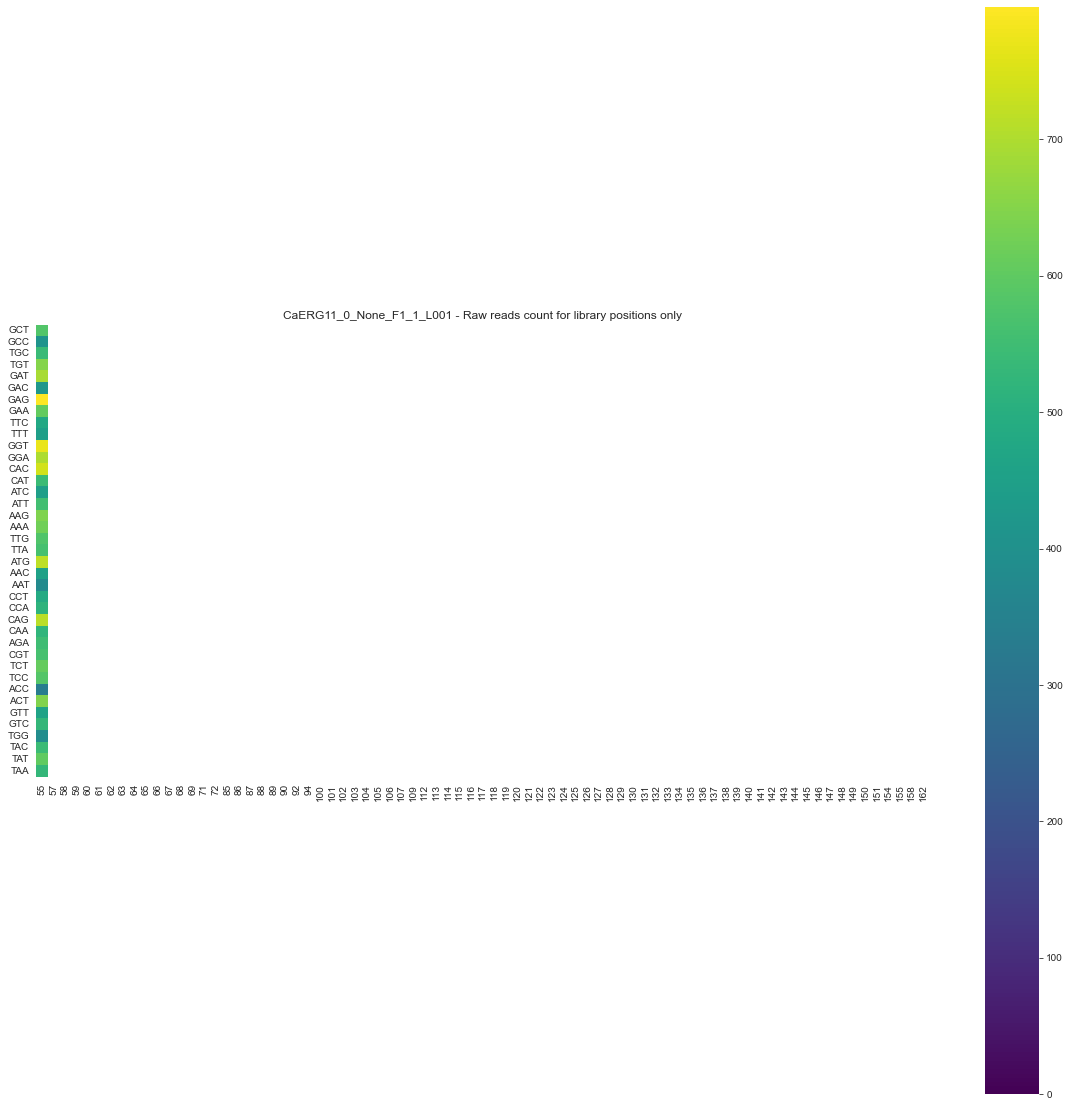

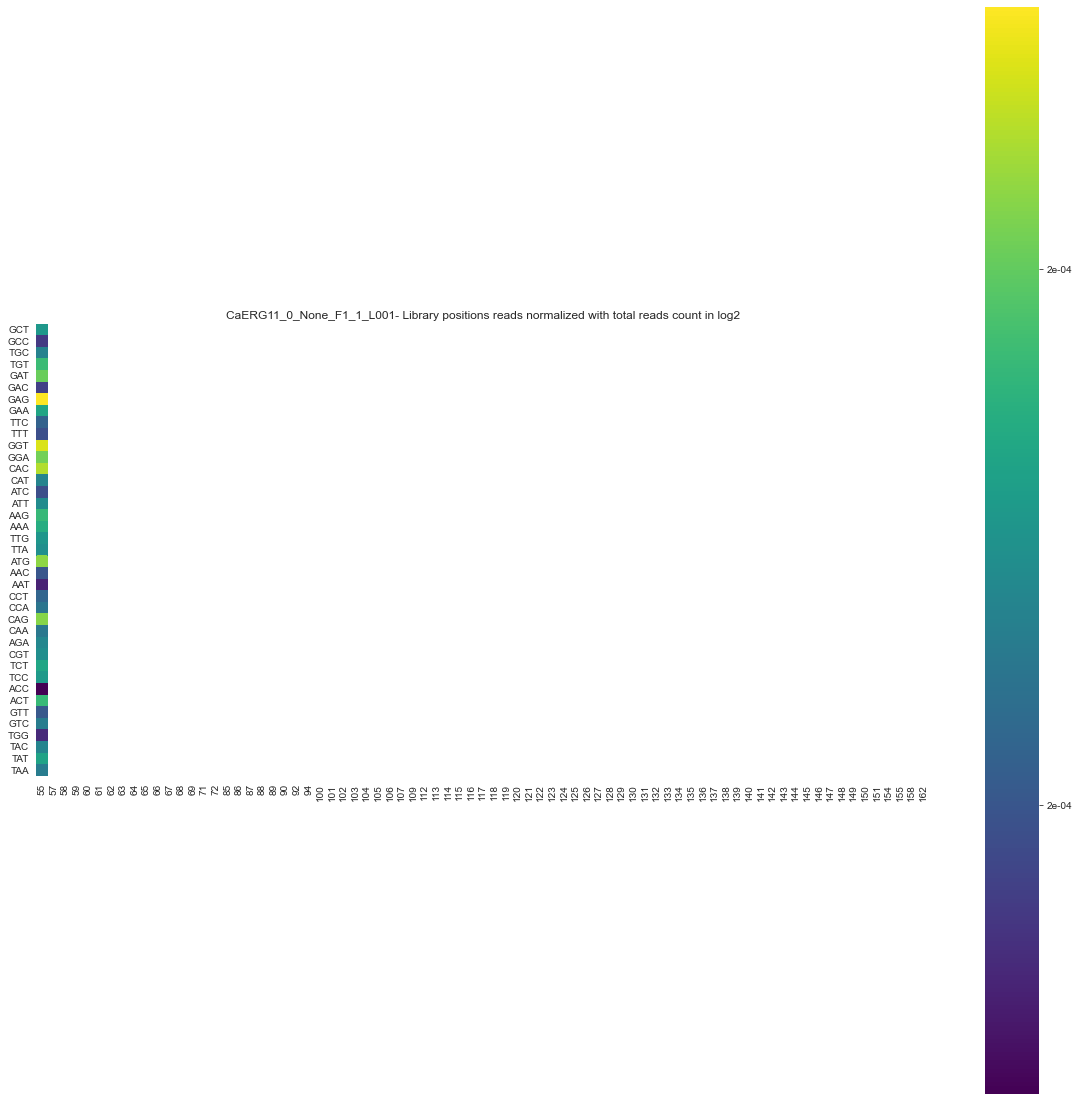

In [33]:

###TADA using every function defined earlier

wt_count_dict = {}
align_seq_dict = {}

for Sample in list(info.index):
    
    input_seq = needle_folder +str(info.loc[Sample]['Name'])+ '.needle' #path to the needle files
    
    ##find mutation function, parse_sequence is in it
    mut = find_mutations(input_seq, wt_seq) 
    nbr_aa = (len(wt_aa))

    nbr_align = get_n_align(mut)
    
    ##Get variant count   get_variant_count_1(mutation_set, ref_seq, frag_start, codon_start, n_aa)
    print((info.loc[Sample]['Name']))
    variants = get_variant_count_1(mut, wt_seq, 0, aa_start,nbr_aa) 
    exp = str(info.loc[Sample]['Name'])
    
    df = pd.DataFrame(variants[0]) ##build a dataframe from the variants we got
    df = df.reindex(index = codons_all)
    name = variants_folder + "Variants_count_all_" + exp+"_" + date  
    df.to_excel(f"{name}.xlsx")    ##save it
    df.to_csv(f"{name}.csv")
    
    dflog = np.log2(df)
    
    df2 = df[pos_mutated]
    df2 = df2.loc[codons_mutated]
    name = variants_folder + "Variants_count_mut_" + exp+"_" + date  
    df2.to_excel(f"{name}.xlsx")    ##save it
    df2.to_csv(f"{name}.csv")
    
    df2log = np.log2(df2)
    
    wt_count_dict[str(info.loc[Sample]["Name"])] = variants[1] #getting the number of WT
    align_seq_dict[str(info.loc[Sample]["Name"])] = nbr_align #getting the number of sequences that passed the needle filter
    
    ##heatmap showing the variants counts 
    #1
    plt.subplots(figsize=(40,15))
    title = str(info.loc[Sample]['Name']) + " - Raw reads count in log2 for all positions"

    sns.set_style("white")
    sns.heatmap(dflog, square=True,cmap = "viridis",cbar_kws={'ticks':MaxNLocator(2), 'format':'%.e'},vmin=0).set(title=title)
    name = heatmaps_folder + "Heatmap_variants_all_log_" + exp+"_" + date  
    plt.savefig(f"{name}.png", format='png', dpi=300) #save it
    
    #2
    plt.subplots(figsize=(40,15))
    title = str(info.loc[Sample]['Name']) + " - Raw reads count for all positions"

    sns.set_style("white")
    sns.heatmap(df, square=True,cmap = "viridis",vmin=0).set(title=title)
    name = heatmaps_folder + "Heatmap_variants_all_" + exp+"_" + date  
    plt.savefig(f"{name}.png", format='png', dpi=300) #save it
    
    #3
    plt.subplots(figsize=(20,20))
    title = str(info.loc[Sample]['Name']) + " - Raw reads count in log2 for library positions only"

    sns.set_style("white")
    sns.heatmap(df2log, square=True,cmap = "viridis",cbar_kws={'ticks':MaxNLocator(2), 'format':'%.e'},vmin=0).set(title=title)
    name = heatmaps_folder + "Heatmap_variants_mut_log_" + exp +"_" + date  
    plt.savefig(f"{name}.png", format='png', dpi=300) #save it   
    
    #4
    plt.subplots(figsize=(20,20)) 
    title = str(info.loc[Sample]['Name'])+ " - Raw reads count for library positions only"

    sns.set_style("white")
    sns.heatmap(df2, square=True,cmap = "viridis",vmin=0).set(title=title)
    name = heatmaps_folder + "Heatmap_variants_mut_" + exp+"_" + date  
    plt.savefig(f"{name}.png", format='png', dpi=300) #save it 
    
    #5
    df2_freq = df2/nbr_align
    df2_freq_log = np.log2(df2_freq +1)
    name = variants_folder + "Variants_count_mut_normalised" + exp+"_" + date  
    df2_freq.to_excel(f"{name}.xlsx")    ##save it
    df2_freq.to_csv(f"{name}.csv")
    
    plt.subplots(figsize=(20,20))
    title = str(info.loc[Sample]['Name'])+ "- Library positions reads normalized with total reads count in log2"

    sns.set_style("white")
    sns.heatmap(df2_freq_log, square=True,cmap = "viridis",cbar_kws={'ticks':MaxNLocator(2), 'format':'%.e'}).set(title=title)
    name = heatmaps_folder + "Heatmap_Freq_DMS_variants_log_" + exp +"_" + date  
    plt.savefig(f"{name}.png", format='png', dpi=300) #save it  

In [ ]:
wt_count_dict

In [ ]:
reads_align = pd.DataFrame.from_dict(after_align_dict, orient="index", columns = ["reads_align"])

wt_count = pd.DataFrame.from_dict(wt_count_dict, orient="index", columns = ["reads_wt"])

In [ ]:
reads = pd.concat([reads, reads_align], axis=1)
reads = pd.concat([reads, wt_count], axis=1)

In [ ]:
##concat all the reads counts

reads['percent_after_align'] = (reads['reads_align'] / reads['reads_after_merge'])*100
reads['percent_WT_seq_align'] = (reads['reads_wt'] / reads['reads_align'])*100
reads['percent_WT_seq_after_merge'] = (reads['reads_wt'] / reads['reads_after_merge'])*100

name = reads_counts_folder + "Reads_count_" + experiment +"_" + date  
reads.to_excel(f"{name}.xlsx")    ##save it
reads.to_csv(f"{name}.csv")

In [ ]:
##supperpose total reads and WT

fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(111)
ax.bar(x=info["Name"], height=reads_align['reads_align'], width=0.35,align='center')
ax.bar(x=info["Name"], height=wt_count['wt_count'], width=0.35/2,  align='center')
plt.yscale("log", base=2)
plt.title("Total number of aligned reads and WT", size=12)
plt.xticks(rotation=90, size =8)
plt.ylabel('Number of reads in log2', size=12)

name = figures_folder + "Proportion_WT_" + experiment+"_" + date  
plt.savefig(f"{name}.png", format='png', dpi=300,bbox_inches="tight")
plt.show()

In [ ]:
##supperpose merge total reads and aligned

fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(111)
ax.bar(x=info["Name"], height=reads['reads_after_merge'], width=0.35,align='center')
ax.bar(x=info["Name"], height=reads_align['reads_align'], width=0.35/2,  align='center')
plt.yscale("log", base=2)
plt.title("Total number of merged and aligned reads", size=12)
plt.xticks(rotation=90, size =8)
plt.ylabel('Number of reads in log2', size=12)

name = figures_folder + "Merge_Aligned_" + experiment+"_" + date  
plt.savefig(f"{name}.png", format='png', dpi=300,bbox_inches="tight")
plt.show()